In [ ]:
import pandas as pd

df = pd.read_excel('/content/Data_Inflasi.xlsx')
df

,Periode,Data Inflasi
0,Januari 2003,8.68 %
1,Februari 2003,7.6 %
2,Maret 2003,7.17 %
3,April 2003,7.62 %
4,Mei 2003,7.15 %
...,...,...
255,April 2024,3 %
256,Mei 2024,2.84 %
257,Juni 2024,2.51 %
258,Juli 2024,2.13 %


# **Pra-Proses**

In [ ]:
# Mengganti nama bulan dari bahasa Indonesia ke bahasa Inggris
bulan_dict = {
    'Januari': 'January', 'Februari': 'February', 'Maret': 'March', 'April': 'April',
    'Mei': 'May', 'Juni': 'June', 'Juli': 'July', 'Agustus': 'August',
    'September': 'September', 'Oktober': 'October', 'November': 'November', 'Desember': 'December'
}
df['Periode'] = df['Periode'].replace(bulan_dict, regex=True)

# konversi ke datetime
df['Periode'] = pd.to_datetime(df['Periode'])
df.set_index('Periode', inplace=True)

<ipython-input-155-106cf47a569b>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Periode'] = pd.to_datetime(df['Periode'])


In [ ]:
# Ubah kolom 'Data Inflasi' menjadi string
df['Data Inflasi'] = df['Data Inflasi'].astype(str)

## Bersihkan data dengan menghapus spasi dan karakter non-numerik yang tidak perlu
df['Data Inflasi'] = df['Data Inflasi'].str.replace(r'[^\d.]+', '', regex=True)

## Ulangi konversi ke numerik
df['Data Inflasi'] = pd.to_numeric(df['Data Inflasi'], errors='coerce')

## Cek apakah ada NaN setelah konversi
nan_count = df['Data Inflasi'].isna().sum()
print(f'Jumlah NaN di kolom "Data Inflasi": {nan_count}')

Jumlah NaN di kolom "Data Inflasi": 0


In [ ]:
print(df)

            Data Inflasi
Periode                 
2003-01-01          8.68
2003-02-01          7.60
2003-03-01          7.17
2003-04-01          7.62
2003-05-01          7.15
...                  ...
2024-04-01          3.00
2024-05-01          2.84
2024-06-01          2.51
2024-07-01          2.13
2024-08-01          2.12

[260 rows x 1 columns]


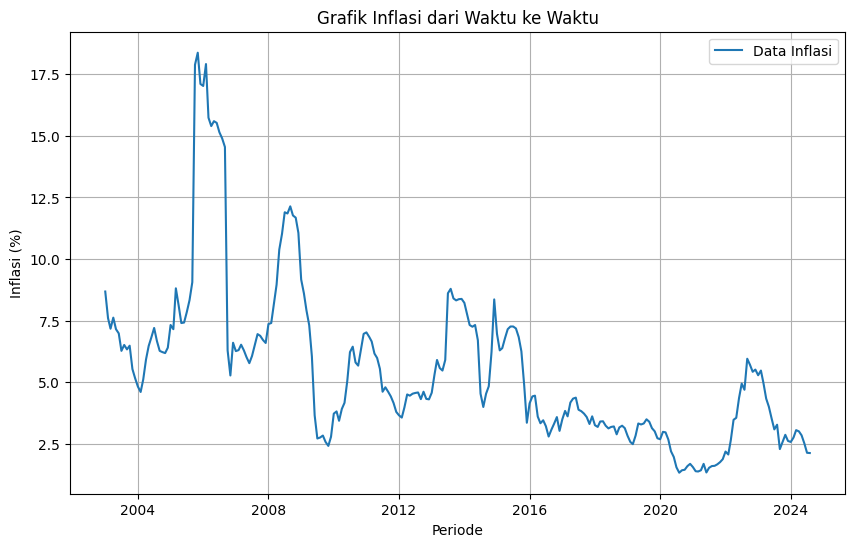

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi Data
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Data Inflasi'], label='Data Inflasi')
plt.xlabel('Periode')
plt.ylabel('Inflasi (%)')
plt.title('Grafik Inflasi dari Waktu ke Waktu')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Membagi Dataset (Hold-Out 80:20)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# **SARIMA**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Fungsi Uji ADF
def uji_adf(data):
    adf_result = adfuller(data.dropna())
    print(f'Uji ADF Statistik: {adf_result[0]}')
    print(f'P-Value: {adf_result[1]}')
    return adf_result[1]

# Cek stasioneritas data
print("Uji ADF:")
p_value_train = uji_adf(train['Data Inflasi'])
if p_value_train < 0.05:
    print("Data sudah stasioner.")
else:
    print("Data belum stasioner.")

Uji ADF:
Uji ADF Statistik: -1.6971735220111344
P-Value: 0.432569348633752
Data belum stasioner.


<ipython-input-161-2d536e37e899>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Data Inflasi Differenced'] = differencing_pertama(train['Data Inflasi'])


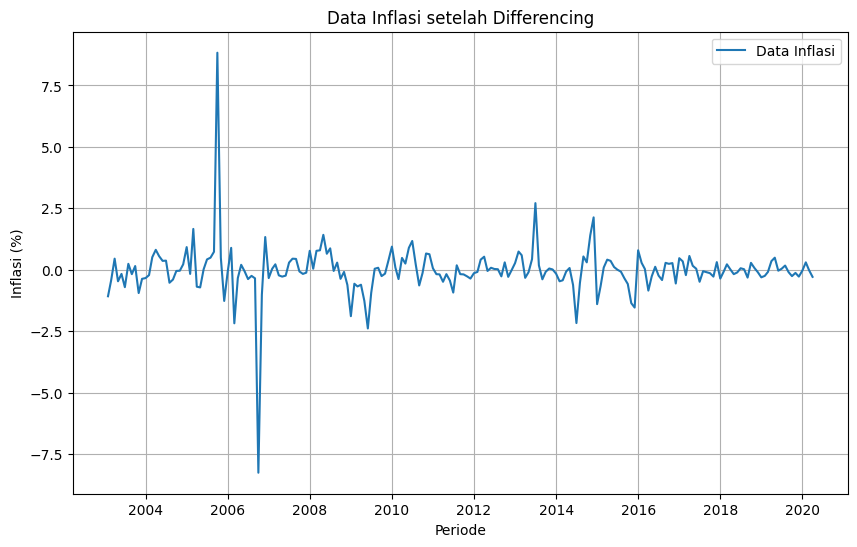

In [ ]:
# Fungsi differencing pertama
def differencing_pertama(data):
    return data.diff()
train['Data Inflasi Differenced'] = differencing_pertama(train['Data Inflasi'])

# Visualisasi data setelah differencing pertama
plt.figure(figsize=(10, 6))
plt.plot(train['Data Inflasi Differenced'], label='Data Inflasi')
plt.xlabel('Periode')
plt.ylabel('Inflasi (%)')
plt.title('Data Inflasi setelah Differencing')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Cek stasioneritas data setelah differencing pertama
p_value_diff = uji_adf(train['Data Inflasi Differenced'])
if p_value_diff < 0.05:
    print("Data sudah stasioner setelah differencing pertama.")
else:
    print("Data belum stasioner setelah differencing pertama.")

Uji ADF Statistik: -6.80039596795065
P-Value: 2.244770162796915e-09
Data sudah stasioner setelah differencing pertama.


In [ ]:
# Periksa apakah ada NaN setelah differencing
nan_mean = train['Data Inflasi Differenced'].isnull().sum()
if nan_mean > 0:
    print(f"Terdapat {nan_mean} nilai NaN setelah differencing terhadap mean.")
else:
    print("Tidak ada nilai NaN setelah differencing terhadap mean.")

Terdapat 1 nilai NaN setelah differencing terhadap mean.


In [ ]:
# Hapus baris yang mengandung nilai NaN
train.dropna(inplace=True)

<ipython-input-164-2d25a70ddc82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


In [ ]:
from statsmodels.stats.diagnostic import het_arch

# Fungsi uji heteroskedastisitas menggunakan ARCH
def uji_heteroskedastisitas(data):
    test_statistic, p_value, _, _ = het_arch(data)
    print(f"Test Statistic: {test_statistic}")
    print(f"P-Value: {p_value}")
    return p_value

# Uji heteroskedastisitas
p_value_heteroskedastisitas = uji_heteroskedastisitas(train['Data Inflasi'].dropna())
if p_value_heteroskedastisitas < 0.05:
    print("Data menunjukkan adanya heteroskedastisitas, yang berarti varians tidak stasioner.")
else:
    print("Data tidak menunjukkan heteroskedastisitas, varians cenderung stasioner.")

Test Statistic: 174.1571513855884
P-Value: 3.8182633554464015e-32
Data menunjukkan adanya heteroskedastisitas, yang berarti varians tidak stasioner.


In [ ]:
import numpy as np

# Transformasi logaritma pada data inflasi
train['Data Inflasi Log'] = train['Data Inflasi'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Fungsi differencing
def differencing_pertama(series):
    return series.diff()

# Lakukan differencing setelah transformasi log
train['Data Inflasi Log Differenced'] = differencing_pertama(train['Data Inflasi Log'])

<ipython-input-166-f3566c752fff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Data Inflasi Log'] = train['Data Inflasi'].apply(lambda x: np.log(x) if x > 0 else np.nan)
<ipython-input-166-f3566c752fff>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Data Inflasi Log Differenced'] = differencing_pertama(train['Data Inflasi Log'])


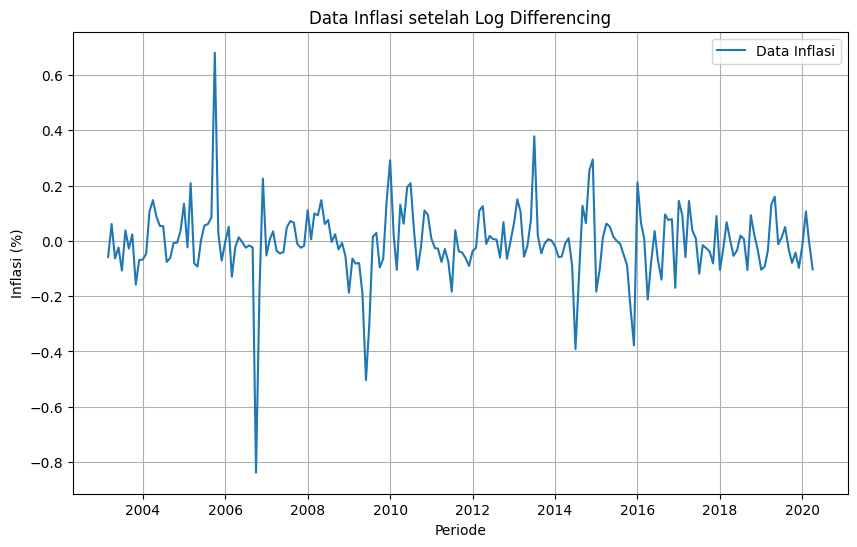

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi data setelah log differencing
plt.figure(figsize=(10, 6))
plt.plot(train['Data Inflasi Log Differenced'].dropna(), label='Data Inflasi')
plt.xlabel('Periode')
plt.ylabel('Inflasi (%)')
plt.title('Data Inflasi setelah Log Differencing')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Uji heteroskedastisitas ulang setelah log differencing
p_value_heteroskedastisitas_log = uji_heteroskedastisitas(train['Data Inflasi Log Differenced'].dropna())
if p_value_heteroskedastisitas_log < 0.05:
    print("Data menunjukkan adanya heteroskedastisitas setelah log differencing.")
else:
    print("Data tidak menunjukkan heteroskedastisitas setelah log differencing.")

Test Statistic: 2.4383624449571157
P-Value: 0.9917438038432494
Data tidak menunjukkan heteroskedastisitas setelah log differencing.


In [ ]:
# Hapus baris yang mengandung nilai NaN
train.dropna(inplace=True)

# Cek apakah masih ada nilai NaN
print(train.isna().sum())

Data Inflasi                    0
Data Inflasi Differenced        0
Data Inflasi Log                0
Data Inflasi Log Differenced    0
dtype: int64


<ipython-input-169-5469c8311b43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


<Figure size 1000x600 with 0 Axes>

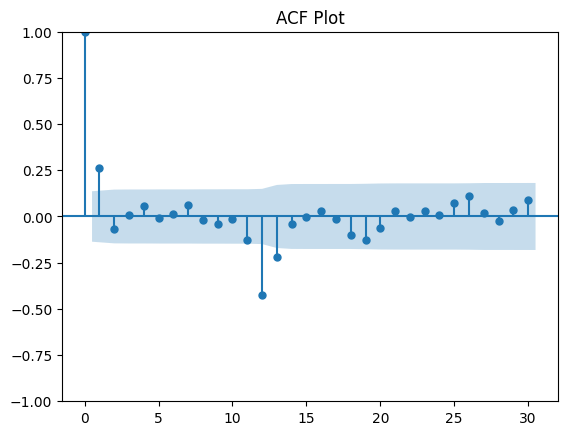

<Figure size 1000x600 with 0 Axes>

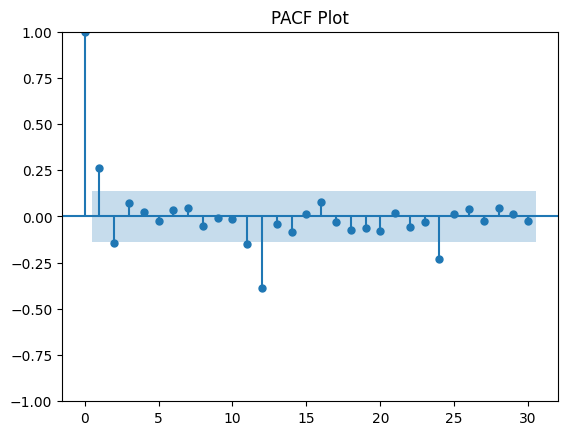

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(train['Data Inflasi Log Differenced'].dropna(), lags=30)
plt.title('ACF Plot')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(train['Data Inflasi Log Differenced'].dropna(), lags=30)
plt.title('PACF Plot')
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_order = (1, 1, 1)
best_seasonal_order = (1, 1, 1, 12)

# Melatih Model SARIMA
model = SARIMAX(
    train['Data Inflasi Log Differenced'].dropna(),
    order=best_order,
    seasonal_order=best_seasonal_order
)
sarima_model = model.fit(disp=False)

# Ringkasan hasil model
print(sarima_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:       Data Inflasi Log Differenced   No. Observations:                  206
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 110.100
Date:                            Sun, 16 Mar 2025   AIC                           -210.200
Time:                                    08:22:51   BIC                           -193.887
Sample:                                03-01-2003   HQIC                          -203.594
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2043      0.091      2.247      0.025       0.026       0.382
ma.L1         -0.9964      0.382   

            Data Aktual  Prediksi
Periode                          
2020-05-01         2.19  2.447567
2020-06-01         1.96  2.360675
2020-07-01         1.54  2.261103
2020-08-01         1.32  2.179613
2020-09-01         1.42  2.152242
2020-10-01         1.44  2.144642
2020-11-01         1.59  2.084291
2020-12-01         1.68  2.123483
2021-01-01         1.55  2.145387
2021-02-01         1.38  2.042252
2021-03-01         1.37  2.053736
2021-04-01         1.42  2.143494


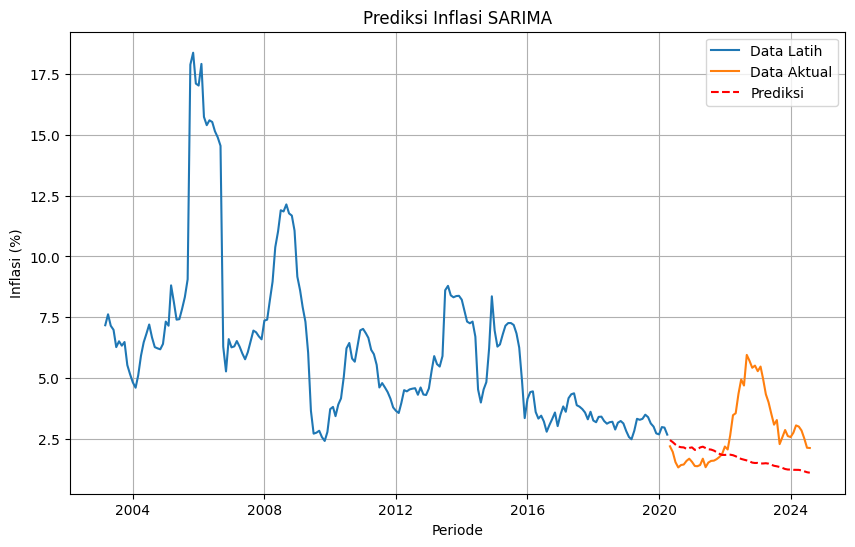

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Prediksi pada data uji
predictions = sarima_model.get_forecast(steps=len(test))
predicted_mean = predictions.predicted_mean

# Fungsi untuk membalikkan differencing dan log transformasi
def reverse_transformation(predictions, original_series):
    undifferenced = predictions.cumsum() + original_series.iloc[-1]  # Undo differencing
    restored = np.exp(undifferenced)  # Undo log transformasi
    return restored

# Membalikkan prediksi ke skala asli
restored_predictions = reverse_transformation(predicted_mean, train['Data Inflasi Log'])

# Dataframe perbandingan
comparison_df = pd.DataFrame({
    'Data Aktual': test['Data Inflasi'].values,
    'Prediksi': restored_predictions.values
}, index=test.index)

print(comparison_df.head(12))

# Plot Perbandingan
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Data Inflasi'], label='Data Latih')
plt.plot(test.index, test['Data Inflasi'], label='Data Aktual')
plt.plot(test.index, restored_predictions, label='Prediksi', color='red', linestyle='--')
plt.xlabel('Periode')
plt.ylabel('Inflasi (%)')
plt.title('Prediksi Inflasi SARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Matrik Evaluasi Model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sarima = mean_absolute_error(test['Data Inflasi'], restored_predictions)
mse_sarima = mean_squared_error(test['Data Inflasi'], restored_predictions)
rmse_sarima = np.sqrt(mse_sarima)

<ipython-input-174-fbac9fb81f00>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='M')[1:]


Prediksi Masa Depan:
2024-09-30    2.447567
2024-10-31    2.360675
2024-11-30    2.261103
2024-12-31    2.179613
2025-01-31    2.152242
2025-02-28    2.144642
2025-03-31    2.084291
2025-04-30    2.123483
2025-05-31    2.145387
2025-06-30    2.042252
2025-07-31    2.053736
2025-08-31    2.143494
Freq: ME, Name: predicted_mean, dtype: float64


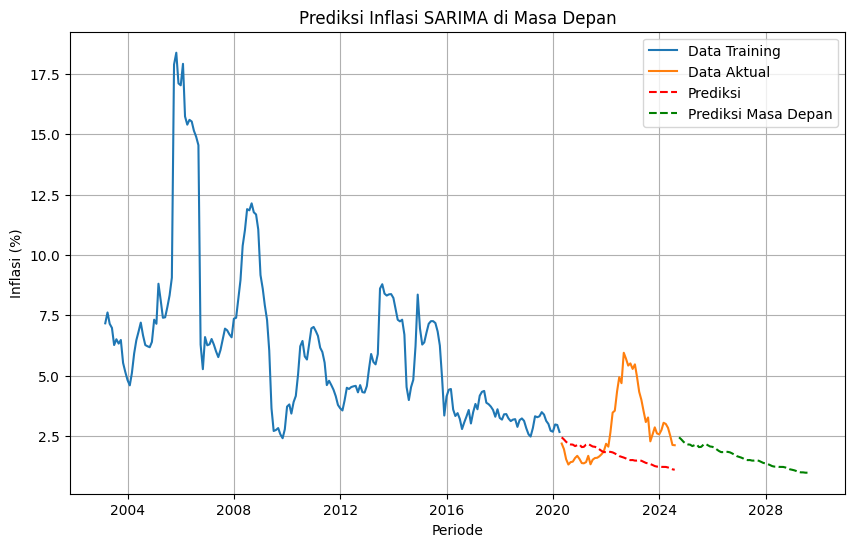

In [ ]:
# Prediksi Masa Depan
future_steps = 60
future_predictions = sarima_model.get_forecast(steps=future_steps)
future_predicted_mean = future_predictions.predicted_mean

# Membuat indeks untuk prediksi masa depan
last_date = test.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='M')[1:]
future_predicted_mean.index = future_dates

# Membalikkan transformasi ke skala asli
restored_future_predictions = reverse_transformation(future_predicted_mean, train['Data Inflasi Log'])

# Tampilkan hasil prediksi masa depan
print("Prediksi Masa Depan:")
print(restored_future_predictions.head(12))

# Plot Prediksi Masa Depan
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Data Inflasi'], label='Data Training')
plt.plot(test.index, test['Data Inflasi'], label='Data Aktual')
plt.plot(test.index, restored_predictions, label='Prediksi', color='red', linestyle='--')
plt.plot(future_predicted_mean.index, restored_future_predictions, label='Prediksi Masa Depan', color='green', linestyle='--')
plt.xlabel('Periode')
plt.ylabel('Inflasi (%)')
plt.title('Prediksi Inflasi SARIMA di Masa Depan')
plt.legend()
plt.grid(True)
plt.show()

# **SVR**

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Pisahkan fitur (X) dan target (y)
X_train = train.index.astype('int64').values.reshape(-1, 1)
y_train = train['Data Inflasi'].values
X_test = test.index.astype('int64').values.reshape(-1, 1)
y_test = test['Data Inflasi'].values

# Standarisasi fitur dan target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Optimasi hyperparameter menggunakan GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

# Gunakan model terbaik dari GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 1, 'epsilon': 0.5, 'gamma': 'auto'}


In [ ]:
# Latih model terbaik
best_model.fit(X_train_scaled, y_train_scaled)

SVR(C=1, epsilon=0.5, gamma='auto')

Tabel Perbandingan Data Inflasi Aktual dan Prediksi:
            Data Aktual  Data Prediksi
Periode                               
2020-05-01         2.19       3.038890
2020-06-01         1.96       3.061740
2020-07-01         1.54       3.085721
2020-08-01         1.32       3.112324
2020-09-01         1.42       3.140669
2020-10-01         1.44       3.169651
2020-11-01         1.59       3.201092
2020-12-01         1.68       3.232858
2021-01-01         1.55       3.266958
2021-02-01         1.38       3.302242
2021-03-01         1.37       3.335037
2021-04-01         1.42       3.372271


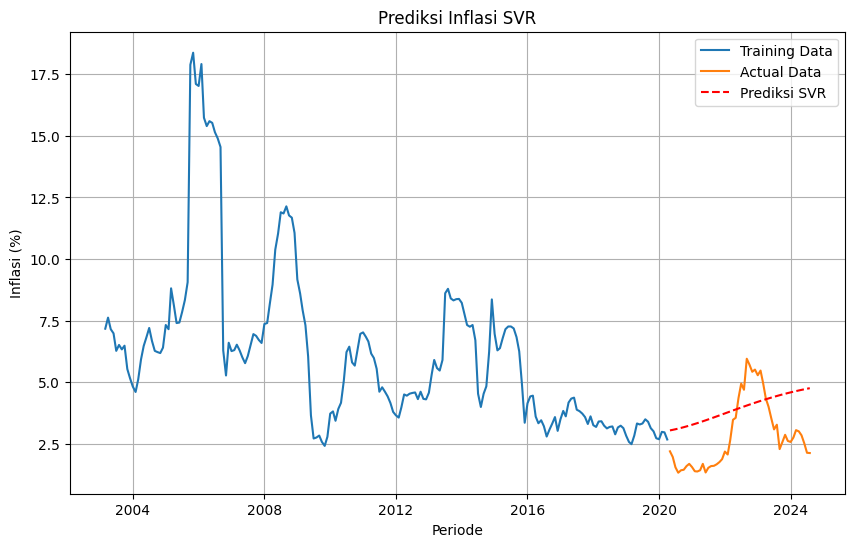

In [ ]:
# Prediksi menggunakan model pada data uji
y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Membuat DataFrame untuk membandingkan hasil prediksi dan nilai aktual
hasil_prediksi = pd.DataFrame({
    'Periode': test.index,
    'Data Aktual': y_test,
    'Data Prediksi': y_pred
})
hasil_prediksi.set_index('Periode', inplace=True)

print("Tabel Perbandingan Data Inflasi Aktual dan Prediksi:")
print(hasil_prediksi.head(12))

# Visualisasi hasil prediksi dan data asli
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Data Inflasi'], label='Training Data')
plt.plot(test.index, test['Data Inflasi'], label='Actual Data')
plt.plot(test.index, y_pred, label='Prediksi SVR', color='red', linestyle='--')
plt.xlabel('Periode')
plt.ylabel('Inflasi (%)')
plt.title('Prediksi Inflasi SVR')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Matrik Evaluasi Model
mae_svr = mean_absolute_error(y_test, y_pred)
mse_svr = mean_squared_error(y_test, y_pred)
rmse_svr = np.sqrt(mse_svr)

Tabel Prediksi Data Inflasi Masa Depan:
            Prediksi Data Inflasi
Periode                          
2024-09-01               4.775270
2024-10-01               4.795210
2024-11-01               4.815023
2024-12-01               4.833442
2025-01-01               4.851711
2025-02-01               4.869219
2025-03-01               4.884393
2025-04-01               4.900501
2025-05-01               4.915413
2025-06-01               4.930143
2025-07-01               4.943756
2025-08-01               4.957181


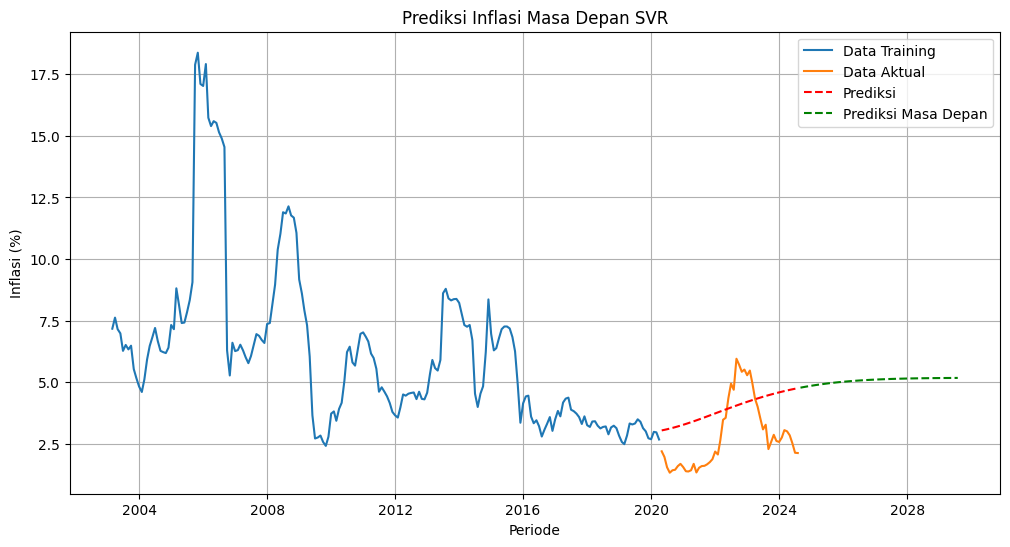

In [ ]:
# Prediksi masa depan
future_periods = 60
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=future_periods, freq='MS')
future_X = future_dates.astype('int64').values.reshape(-1, 1)
future_X_scaled = scaler_X.transform(future_X)

future_pred_scaled = best_model.predict(future_X_scaled)
future_pred = scaler_y.inverse_transform(future_pred_scaled.reshape(-1, 1)).ravel()

# Membuat DataFrame untuk hasil prediksi masa depan
hasil_prediksi_masa_depan = pd.DataFrame({
    'Periode': future_dates,
    'Prediksi Data Inflasi': future_pred
})
hasil_prediksi_masa_depan.set_index('Periode', inplace=True)

print("Tabel Prediksi Data Inflasi Masa Depan:")
print(hasil_prediksi_masa_depan.head(12))

# Gabungkan data historis dengan prediksi masa depan untuk visualisasi
all_data = pd.concat([df, hasil_prediksi_masa_depan])

# Visualisasi data historis dan prediksi masa depan
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Data Inflasi'], label='Data Training')
plt.plot(test.index, test['Data Inflasi'], label='Data Aktual')
plt.plot(test.index, y_pred, label='Prediksi', color='red', linestyle='--')
plt.plot(hasil_prediksi_masa_depan.index, hasil_prediksi_masa_depan['Prediksi Data Inflasi'],
         label='Prediksi Masa Depan', color='green', linestyle='--')
plt.xlabel('Periode')
plt.ylabel('Inflasi (%)')
plt.title('Prediksi Inflasi Masa Depan SVR')
plt.legend()
plt.grid(True)
plt.show()

# **EVALUASI AKHIR**

In [ ]:
# Tabel evaluasi akhir untuk semua model
eval_df = pd.DataFrame({
    'Model': ['SARIMA', 'SVR'],
    'MAE': [mae_sarima, mae_svr],
    'MSE': [mse_sarima, mse_svr],
    'RMSE': [rmse_sarima, rmse_svr],
})

print("Evaluasi Akhir Model Prediksi Inflasi:")
print(eval_df)

Evaluasi Akhir Model Prediksi Inflasi:
    Model       MAE       MSE      RMSE
0  SARIMA  1.528837  3.823869  1.955471
1     SVR  1.520851  2.648495  1.627420


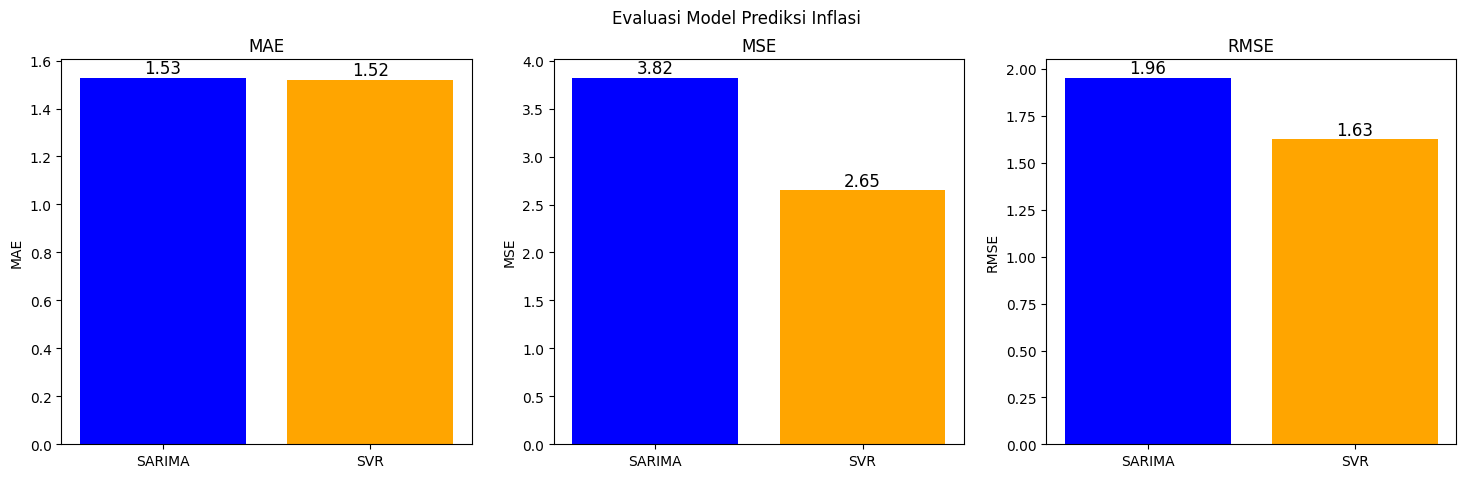

In [ ]:
# Plot metrik evaluasi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['MAE', 'MSE', 'RMSE']
colors = ['blue', 'orange']

for i, metric in enumerate(metrics):
    bars = axes[i].bar(eval_df['Model'], eval_df[metric], color=colors)
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)

    # Menambahkan nilai di atas batang
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}',
                     ha='center', va='bottom', fontsize=12)

plt.suptitle('Evaluasi Model Prediksi Inflasi')
plt.show()